# Kerchunk, GeoTIFF and Generating Coordinates with `xrefcoord`


<img src="../images/radar.png" width=400 alt="ARG"></img>

## Overview

In this tutorial we will cover:

1. How to generate `Kerchunk` references of GeoTIFFs.
1. Combining `Kerchunk` references into a virtual dataset.
1. Generating Coordinates with the `xrefcoord` accessor.


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Kerchunk Basics](../foundations/kerchunk_basics) | Required | Core |
| [Multiple Files and Kerchunk](../foundations/kerchunk_multi_file) | Required | Core |
| [Kerchunk and Dask](../foundations/kerchunk_dask) | Required | Core |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Required | IO/Visualization |
- **Time to learn**: 30 minutes
---

## About the Dataset

The Finish Meterological Institute (FMI) Weather Radar Dataset is a collection of GeoTIFF files containing multiple radar specific variables, such as rainfall intensity, precipitation accumulation (in 1, 12 and 24 hour increments),  radar reflectivity, radial velocity, rain classification and the cloud top height. It is available through the [AWS public data portal](https://aws.amazon.com/marketplace/pp/prodview-koodet467asui?sr=0-19&ref_=beagle&applicationId=AWSMPContessa) and is updated frequently. 



More details on this dataset can be found [here](https://en.ilmatieteenlaitos.fi/radar-data-on-aws-s3).


In [1]:
import glob
import logging
from tempfile import TemporaryDirectory

import dask
import fsspec
import numpy as np
import pandas as pd
import rioxarray
import s3fs
import ujson
import xarray as xr
import xrefcoord  # noqa
from distributed import Client
from kerchunk.combine import MultiZarrToZarr
from kerchunk.tiff import tiff_to_zarr
from tqdm import tqdm

### Examining a Single GeoTIFF File

Before we use `Kerchunk` to create indices for multiple files, we can load a single GeoTiff file to examine it. 


In [ ]:
# URL pointing to a single GeoTIFF file
url = "s3://fmi-opendata-radar-geotiff/2023/07/01/FIN-ACRR-3067-1KM/202307010100_FIN-ACRR1H-3067-1KM.tif"

# Initialize a s3 filesystem
fs = s3fs.S3FileSystem(anon=True)

xds = rioxarray.open_rasterio(fs.open(url))

In [ ]:
xds

In [ ]:
xds.isel(band=0).where(xds < 2000).plot()

## Create Input File List

Here we are using `fsspec's` glob functionality along with the *`*`* wildcard operator and some string slicing to grab a list of GeoTIFF files from a `s3` `fsspec` filesystem. 

In [3]:
# Initiate fsspec filesystems for reading
fs_read = fsspec.filesystem("s3", anon=True, skip_instance_cache=True)

files_paths = fs_read.glob(
    "s3://fmi-opendata-radar-geotiff/2023/01/01/FIN-ACRR-3067-1KM/*24H-3067-1KM.tif"
)
# Here we prepend the prefix 's3://', which points to AWS.
file_pattern = sorted(["s3://" + f for f in files_paths])

In [4]:
# This dictionary will be passed as kwargs to `fsspec`. For more details, check out the `foundations/kerchunk_basics` notebook.
so = dict(mode="rb", anon=True, default_fill_cache=False, default_cache_type="first")

# We are creating a temporary directory to store the .json reference files
# Alternately, you could write these to cloud storage.
td = TemporaryDirectory()
temp_dir = td.name
temp_dir

'/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw'

## Start a Dask Client

To parallelize the creation of our reference files, we will use `Dask`. For a detailed guide on how to use Dask and Kerchunk, see the Foundations notebook: [Kerchunk and Dask](../foundations/kerchunk_dask).


In [5]:
client = Client(n_workers=8, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55490,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:55509,Total threads: 1
Dashboard: http://127.0.0.1:55510/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:55493,


In [6]:
# Use Kerchunk's `tiff_to_zarr` method to create create reference files


def generate_json_reference(fil, output_dir: str):
    tiff_chunks = tiff_to_zarr(fil, remote_options={"protocol": "s3", "anon": True})
    fname = fil.split("/")[-1].split("_")[0]
    outf = f"{output_dir}/{fname}.json"
    with open(outf, "wb") as f:
        f.write(ujson.dumps(tiff_chunks).encode())
    return outf


# Generate Dask Delayed objects
tasks = [dask.delayed(generate_json_reference)(fil, temp_dir) for fil in file_pattern]

In [7]:
# Start parallel processing
import warnings

warnings.filterwarnings("ignore")
dask.compute(tasks)

(['/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301010100.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301010200.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301010300.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301010400.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301010500.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301010600.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301010700.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301010800.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301010900.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301011000.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301011100.json',
  '/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmpus3k27uw/202301011200

## Combine Reference Files into Multi-File Reference Dataset

Now we will combine all the reference files generated into a single reference dataset. Since each TIFF file is a single timeslice and the only temporal information is stored in the filepath, we will have to specify the `coo_map` kwarg in `MultiZarrToZarr` to build a dimension from the filepath attributes. 



In [8]:
ref_files = sorted(glob.iglob(f"{temp_dir}/*.json"))


# Custom Kerchunk function from `coo_map` to create dimensions
def fn_to_time(index, fs, var, fn):
    import datetime
    import re

    subst = fn.split("/")[-1].split(".json")[0]
    return datetime.datetime.strptime(subst, "%Y%m%d%H%M")


mzz = MultiZarrToZarr(
    path=ref_files,
    indicts=ref_files,
    remote_protocol="s3",
    coo_map={"time": fn_to_time},
    coo_dtypes={"time": np.dtype("M8[s]")},
    concat_dims=["time"],
    identical_dims=["X", "Y"],
)

# # save translate reference in memory for later visualization
multi_kerchunk = mzz.translate()

# Write kerchunk .json record
output_fname = "RADAR.json"
with open(f"{output_fname}", "wb") as f:
    f.write(ujson.dumps(multi_kerchunk).encode())

## Open Combined Reference Dataset

In [9]:
fs = fsspec.filesystem(
    "reference",
    fo="RADAR.json",
    remote_protocol="s3",
    remote_options={"anon": True},
    skip_instance_cache=True,
)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr")

In [ ]:
ds

## Use `xrefcoord` to Generate Coordinates
When using `Kerchunk` to generate reference datasets for GeoTIFF's, only the dimensions are preserved. `xrefcoord` is a small utility that allows us to generate coordinates for these reference datasets using the geospatial metadata. Similar to other accessor add-on libraries for `Xarray` such as `rioxarray` and `xwrf`, `xrefcord` provides an accessor for an `Xarray` dataset. Importing `xrefcoord` allows us to use the `.xref` accessor to access additional methods. 

In the following cell, we will use the `generate_coords` method to build coordinates for the `Xarray` dataset. `xrefcoord` is *very experimental* and makes assumptions about the underlying data, such as each variable shares the same dimensions etc. Use with caution!


In [10]:
# Generate coordinates from reference dataset
ref_ds = ds.xref.generate_coords(time_dim_name="time", x_dim_name="X", y_dim_name="Y")
# Rename to rain accumulation in 24 hour period
ref_ds = ref_ds.rename({"0": "rr24h"})

## Create a Map

Here we are using `Xarray` to select a single time slice and create a map of 24 hour accumulated rainfall.

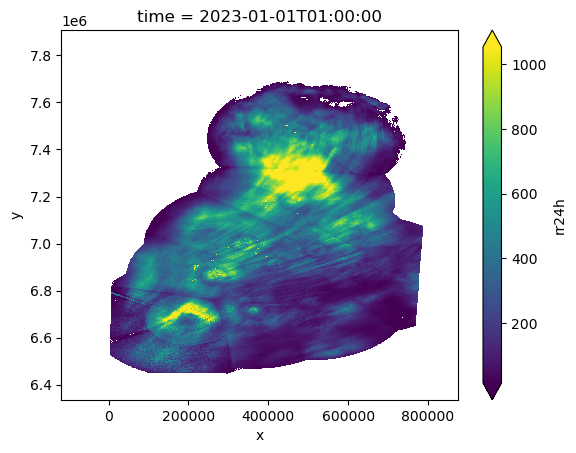

In [11]:
ref_ds["rr24h"].where(ref_ds.rr24h < 60000).isel(time=0).plot(robust=True)

## Create a Time-Series

Next we are plotting accumulated rain as a function of time for a specific point.

In [ ]:
ref_ds["rr24h"][:, 700, 700].plot()